# Notes

## Questions

## Results

## Fig layout


# Import

In [16]:
# expt variables
channel=creb.CHANNEL
label=creb.IMAGING_LABEL
group_labels=creb.labels

# set seaborn pallette

sns.set_style("white")
sns.set_style("ticks")
sns.set_context("talk")

colors = creb.colors
sns.set_palette(colors)

# stats
%load_ext rpy2.ipython

In [17]:
# notebook imports 
import lab.figures.place_cell_figures as pcf
from copy import deepcopy

In [18]:
# variables + functions
activity_labels =  {'pop_vector': 'Population vector correlation',
                    'pf_correlation': 'Place field correlation',
                    'recurrence': 'Recurrence probablity',
                    'centroid_shift':'Centroid shift (cm of belt)'} 

# 2.3 notebook functions 
def just_day(df,shuffle=False):
    df_day = df[df.pairing =='day']
    if shuffle:
        return rm_shuffle(df_day), just_shuffle(df_day)
    else: 
        return rm_shuffle(df_day)

def just_session(df,shuffle=False):
    df_sess = df[df.pairing =='session']
    if shuffle:
        return rm_shuffle(df_sess), just_shuffle(df_sess)
    else: 
        return rm_shuffle(df_sess)

def rm_shuffle(df):
    return df[(df.grp !='shuffle')]

def just_shuffle(df):
    return df[(df.grp =='shuffle')]

def add_same_diff_cols_old(df):
    i_s = df.loc[df["day"].isin(['1','2','3','5','6'])].index
    i_d = df.loc[df["day"] == '4' ].index

    #df.loc[i_s,"reward_loc"] = 'Same'
    df.loc[i_d,"reward_loc"] = 'Different'
    df.loc[i_s,"reward_loc"] = 'Same'
    print(df.groupby(["day","reward_loc"]).count())
    return df


def add_same_diff_cols(df):
    df.loc[df.query("day in ['1','2','3','5','6']").index,"reward_loc"] = 'Different'
    df.loc[df.query("day == '4'").index,"reward_loc"] = 'Same'
    return df

def calc_day_diff(df_mid):
    df3=df_mid.groupby("day").get_group('3')
    df4=df_mid.groupby("day").get_group('4')
    dfm=pd.merge(df3,df4,on=["mouseID","session"])
    dfm["diff"]=dfm.value_x-dfm.value_y
    dfm.rename(columns={'grp_x':'grp'},inplace=True)
    
    return dfm



#df.loc[df.query("grp != 'shuffle' & pairing in 'session'").index,"test"] = 'LOL'

In [50]:
%%R
mixed_anova <- function(input_df) {
    am2 <- with(input_df, lme(value ~ grp * day,random = ~1|mouseID))
    print(anova(am2))
}

ow_anova <- function(input_df) {
    am2 <- with(input_df, lme(value ~ grp))
    print(anova(am2))
}

# Load Groups

In [9]:
exptGrps,roi_filters = creb.load_creb_experiments(filter_type='active')

LOADED EXPERIMENT GROUPS: CREB,dn-CREB,Control
Using filter...active


# Read CSV

In [14]:
# save 
#mjdhelp.save_pickle(all_dfs,'STABILITY-PCEITHER-DAY-SESSION-WITH-SHUFFLE.pkl')

#all_dfs = mjdhelp.read_from_pickle('STABILITY-PCBOTH-DAY-SESSION-WITH-SHUFFLE.pkl')

all_dfs = mjdhelp.read_from_pickle('STABILITY-PCEITHER-DAY-SESSION-WITH-SHUFFLE.pkl')

# remove bad dn session
for key,df in all_dfs.items():
    #df.drop(df.loc[df.trial_id == '12453'].index,inplace=True)
    df.drop(df.query('trial_id == 12813').index,inplace=True)
print(all_dfs.keys())

['recurrence', 'pf_correlation', 'centroid_shift', 'pop_vector']


# Remove day three reward cells

In [34]:
df = all_dfs_roi["pf_correlation"] # centroid shift cause cant get pop vec by roi
df = mjdplot.roi_to_label(df,col="first_roi")
df = just_session(df,shuffle=False)
#df = just_day(df,shuffle=False)


# import the roi labels (generated in reward notbook)
rois_sess3 = pd.read_pickle('day3-sess3-reward-rois.pkl')

# filtered dfs
df_filt_nr=df.query("roi_label not in @rois_sess3")
df_filt_rew=df.query("roi_label in @rois_sess3")

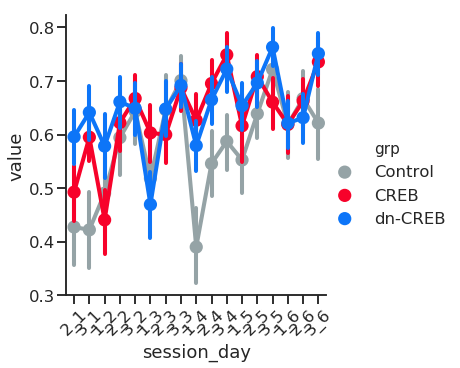

In [77]:
# all cells
g = sns.catplot(kind='point',data=df,x="session_day",y="value",hue="grp")
g.set_xticklabels(rotation=45)

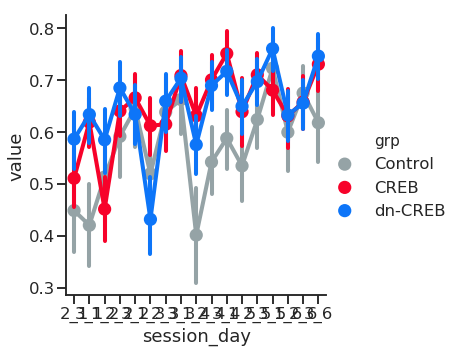

In [78]:
# remove reward cells from whole analysis
sns.catplot(kind='point',data=df_filt_nr,x="session_day",y="value",hue="grp")

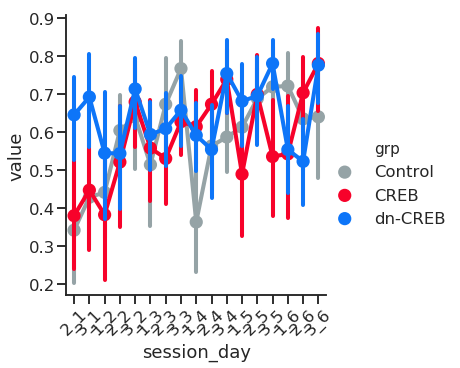

In [95]:
# just reward cells for d3s3, perhaps a bigger shift
g = sns.catplot(kind='point',data=df_filt_rew,x="session_day",y="value",hue="grp")
g.set_xticklabels(rotation=45)

In [55]:
# number of reward cells reward, across all animals
df_filt_rew.groupby(['grp','roi_label']).sum().reset_index().grp.value_counts()

CREB       74
dn-CREB    61
Control    55
Name: grp, dtype: int64

In [56]:
# total cell count 
df.groupby(['grp','roi_label']).sum().reset_index().grp.value_counts()

CREB       728
dn-CREB    507
Control    403
Name: grp, dtype: int64

### just sessions of interest
This will likely be in the paper

In [96]:
# just sessions of interest
df1 = df_filt_rew.query("session_day in ['3_3','1_4']").copy()
df1 = df1.assign(filter = 1)

df2 = df_filt_nr.query("session_day in ['3_3','1_4']").copy()
df2 = df2.assign(filter = 0)


dfm=pd.concat([df1,df2])

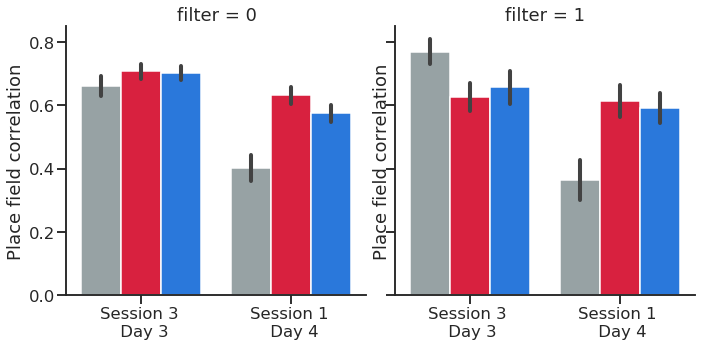

In [126]:
ax = sns.catplot(kind='bar',data=dfm,col ='filter',x="session_day",y="value",hue="grp",ci=68)
(ax.set(xlabel='', 
        ylabel='Place field correlation',
        xticklabels=["Session 3 \n Day 3","Session 1 \n Day 4"])
    ._legend.remove())

ax.savefig('figs/pf-corr-by-reward.svg')

In [101]:
%%R -i df1
# df1, just reward cells

am2 <-aov(value ~ (grp*session_day) + Error(mouseID/(session_day)), data = df1)
print(summary(am2))

/home/matt/anaconda2/lib/python2.7/site-packages/rpy2/robjects/pandas2ri.py:57: UserWarning: Error while trying to convert the column "first_expt". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'lab.classes.experiment.HiddenRewardExperiment'>'
  (name, str(e)))
/home/matt/anaconda2/lib/python2.7/site-packages/rpy2/robjects/pandas2ri.py:57: UserWarning: Error while trying to convert the column "second_roi". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'sima.ROI.ROI'>'
  (name, str(e)))



Error: mouseID
                Df Sum Sq Mean Sq F value Pr(>F)
grp              2 0.0268 0.01342   0.126  0.883
session_day      1 0.0083 0.00826   0.078  0.786
grp:session_day  2 0.0091 0.00456   0.043  0.958
Residuals       10 1.0623 0.10623               

Error: mouseID:session_day
                Df Sum Sq Mean Sq F value  Pr(>F)   
session_day      1  1.617  1.6173  10.543 0.00778 **
grp:session_day  2  1.901  0.9505   6.196 0.01577 * 
Residuals       11  1.688  0.1534                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq Mean Sq F value Pr(>F)
Residuals 243  26.05  0.1072               


In [115]:
for n,g in df1.groupby("session_day"):
    print('\n' + '='*10 + '\n' + 'GROUP: {}'.format(n) + '\n' + '='*10 + '\n')
    stats.full_anova(g,ind_vars=['grp'],dep_var='value')


GROUP: 1_4

# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.069   
Dependent Variable: value            AIC:                105.1762
Date:               2019-12-02 13:20 BIC:                113.8697
No. Observations:   134              Log-Likelihood:     -49.588 
Df Model:           2                F-statistic:        5.931   
Df Residuals:       131              Prob (F-statistic): 0.00342 
R-squared:          0.083            Scale:              0.12554 
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.6145   0.0506 12.1406 0.0000  0.5144  0.7147
C(grp)[T.Control] -0.2505   0.0784 -3.1948 0.0018 -0.4056 -0.0954
C(grp)[T.dn-CREB] -0.0230   0.0712 -0.3225 0.7476 -0.1639  0.1179
------------

In [145]:
%%R -i df2
# df2, non reward cells
am2 <-aov(value ~ grp*session_day, data = df2)
print(summary(am2))

                 Df Sum Sq Mean Sq F value   Pr(>F)    
grp               2   2.02   1.011  10.043 5.00e-05 ***
session_day       1   3.38   3.384  33.607 1.02e-08 ***
grp:session_day   2   0.90   0.450   4.473   0.0117 *  
Residuals       706  71.10   0.101                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [138]:
%%R -i df2
# df2, non reward cells
am2 <-aov(value ~ (grp*session_day) + Error(mouseID/(session_day)), data = df2)
print(summary(am2))


Error: mouseID
                Df Sum Sq Mean Sq F value  Pr(>F)   
grp              2 2.0227  1.0114   9.686 0.00457 **
session_day      1 0.0414  0.0414   0.397 0.54286   
grp:session_day  2 1.5053  0.7526   7.208 0.01152 * 
Residuals       10 1.0441  0.1044                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: mouseID:session_day
                Df Sum Sq Mean Sq F value   Pr(>F)    
session_day      1  3.673   3.673  41.245 3.29e-05 ***
grp:session_day  2  0.733   0.367   4.115   0.0436 *  
Residuals       12  1.069   0.089                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq Mean Sq F value Pr(>F)
Residuals 681  67.32 0.09885               


In [139]:
for n,g in df2.groupby("session_day"):
    print('\n' + '='*10 + '\n' + 'GROUP: {}'.format(n) + '\n' + '='*10 + '\n')
    stats.full_anova(g,ind_vars=['grp'],dep_var='value')


GROUP: 1_4

# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.055   
Dependent Variable: value            AIC:                270.9497
Date:               2019-12-04 12:59 BIC:                282.6576
No. Observations:   366              Log-Likelihood:     -132.47 
Df Model:           2                F-statistic:        11.55   
Df Residuals:       363              Prob (F-statistic): 1.37e-05
R-squared:          0.060            Scale:              0.12176 
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.6307   0.0293 21.5402 0.0000  0.5732  0.6883
C(grp)[T.Control] -0.2297   0.0484 -4.7453 0.0000 -0.3248 -0.1345
C(grp)[T.dn-CREB] -0.0557   0.0414 -1.3443 0.1797 -0.1371  0.0258
------------

# PAIRING + DATA

## pair data

In [10]:
# pairing

# session
session_paired = [
        grp.pair('consecutive groups',
                 groupby=['X_condition', 'X_day', 'X_session'])
        for grp in exptGrps]

# day
day_paired = [grp.pair('same group', groupby=['X_session']).pair(
        'consecutive groups', groupby=['X_condition', 'X_day']) for grp in
        exptGrps]

paired_exptGrps=[session_paired, day_paired]

## check pairing

In [191]:
# check pairing
plist =[]
for grp in day_paired:
    for e1, e2 in grp.genImagedExptPairs():
        plist.append((e1.parent.get('mouseID'),e1.get('day'),e1.get('session'),
             e2.parent.get('mouseID'),e2.get('day'),e2.get('session')))
        
# tried to iterate over pairs to find in df, prob dont need 
#for r in plist:
#    print(df_mid.value[(df_mid.mouseID==r[0]) & (df_mid.day==r[1]) & (df_mid.session==r[2])])
    

## generate data

/home/matt/code/analysis/lab/plotting/plotting_helpers.py:649: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  groupby_list, as_index=False).agg(agg)
/home/matt/code/analysis/lab/plotting/plotting_helpers.py:681: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  groupby_list, as_index=False).agg(agg)


recurrence
pf_correlation
centroid_shift
pop_vector
recurrence
pf_correlation
centroid_shift
pop_vector


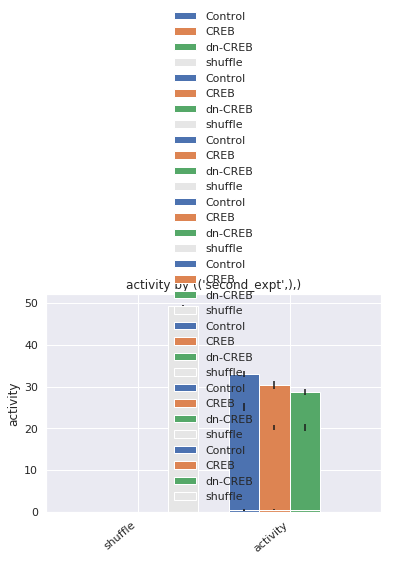

In [11]:
# generate data
data_dicts_both=[]

groupby = (('second_expt',),)
#groupby = (('roi',),)
pc_pairing = 'pc_either' # 'pc_either'
circ_var_pcs = False
fig,ax = plt.subplots(1)


keys=['recurrence',
      'pf_correlation',
      'centroid_shift',
      'pop_vector']

metrics={'recurrence': place.recurrence_probability,
         'pf_correlation': place.place_field_correlation,
         'centroid_shift': place.activity_centroid_shift,
         'pop_vector':place.population_vector_correlation}


activity_kwargs= {'recurrence': None,
                  'pf_correlation': {'activity_filter': pc_pairing},
                  'centroid_shift': {'activity_filter': pc_pairing,
                                     'circ_var_pcs': circ_var_pcs,
                                     'units': 'cm'},
                  'pop_vector': {'method': 'corr', 
                                 'activity_filter': pc_pairing, 
                                 'min_pf_density': 0.05,
                                 'circ_var_pcs': circ_var_pcs}}

activity_labels = ['Recurrence probability',
                  'Place field correlation',
                  'Centroid shift (cm)',
                  'Population vector correlation']

for pair in paired_exptGrps:
    data={}
    for key in keys:
        data[key]=plot_metric(
                ax=ax, exptGrps=pair, roi_filters=roi_filters,
                metric_fn=metrics[key], plot_method='grouped_bar',
                groupby=groupby, plotby=None, activity_kwargs=activity_kwargs[key],
                pool_shuffle=True,plot_shuffle=True)
        print(key)
        
    data_dicts_both.append(data)

## create dataframe

In [12]:
# dataframe from data
data_dicts = data_dicts_both
all_dfs={}

for key in keys:
    dfs=[]
    for d,s in zip(data_dicts,['session','day']):
        df = stats.prep_data(d[key])
        df["pairing"] = s
        dfs.append(df)
    cdf = pd.concat(dfs)
    
    # clean & expand expt
    #cdf = cdf.rename(columns = {"second_expt": "expt"})
    cdf = mjdplot.attrib_to_df(cdf,drop_expt=False).reset_index()
    all_dfs.update({key:cdf})
    
    
mjdhelp.save_pickle(all_dfs,'STABILITY-PCEITHER-DAY-SESSION-WITH-SHUFFLE.pkl')

/home/matt/code/analysis/lab/misc/stats.py:249: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  result = pd.concat(data_dfs, ignore_index=True)


# Single plot - Day vs Session

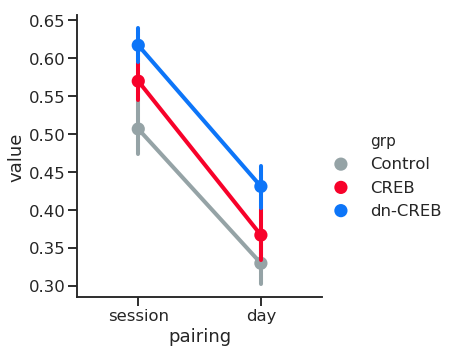

In [16]:
key = 'pop_vector'

sns.catplot(x='pairing',y="value", hue='grp',
            kind="point",data=rm_shuffle(all_dfs[key]))

# Individual mouse plots

 # Pop vector

## key select

In [20]:
print(all_dfs.keys())

key = 'pop_vector'
key_label = 'Population vector correlation'

# select key
df = deepcopy(all_dfs[key])
df,df_shuffle = just_day(df,shuffle=True)


['recurrence', 'pf_correlation', 'pop_vector', 'centroid_shift']


## pop vector overall

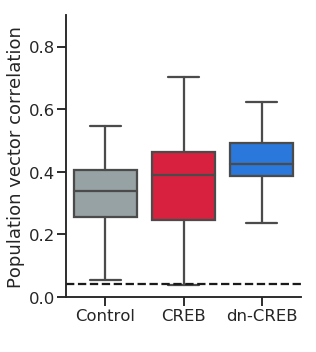

In [21]:
height,width = 5., 4.5
#fig = plt.figure(figsize=(2,5))
#ax = sns.boxplot(x="grp",y="value",data=df,showfliers=False)

g = sns.catplot(x='grp',y="value",
                kind="box",data=df,showfliers=False,
                height=height, aspect=width/height)

# axis
g.set(ylim=(0,.9),ylabel=key_label,xlabel=' ')
sns.despine()

# legend


# shuffle
g.ax.axhline(df_shuffle.value.mean(), linestyle='--', color='k')

# save
#g.savefig('figs/popvec-overall-dpair-pcboth.svg')

In [22]:
%%R -i df
am2 <-aov(value ~ grp, data = df)

print(summary(am2))
TukeyHSD(am2)

/home/matt/anaconda2/lib/python2.7/site-packages/rpy2/robjects/pandas2ri.py:57: UserWarning: Error while trying to convert the column "second_expt". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'lab.classes.experiment.HiddenRewardExperiment'>'
  (name, str(e)))


             Df Sum Sq Mean Sq F value   Pr(>F)    
grp           2  0.345 0.17233   10.15 6.23e-05 ***
Residuals   209  3.550 0.01698                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ grp, data = df)

$grp
                      diff         lwr        upr     p adj
CREB-Control    0.03718926 -0.01335332 0.08773184 0.1939506
dn-CREB-Control 0.10137173  0.04776418 0.15497928 0.0000391
dn-CREB-CREB    0.06418247  0.01236377 0.11600118 0.0106796



In [14]:
%%R -i df
am2 <-aov(value ~ grp, data = df)

print(summary(am2))
TukeyHSD(am2)

             Df Sum Sq Mean Sq F value  Pr(>F)   
grp           2  0.266 0.13297   6.953 0.00119 **
Residuals   208  3.978 0.01912                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ grp, data = df)

$grp
                      diff          lwr        upr     p adj
CREB-Control    0.03980368 -0.014042552 0.09364991 0.1910482
dn-CREB-Control 0.09007536  0.032988683 0.14716205 0.0007339
dn-CREB-CREB    0.05027169 -0.004717415 0.10526079 0.0809680



In [15]:
stats.full_anova(df,ind_vars=['grp'],dep_var='value')

# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.054    
Dependent Variable: value            AIC:                -233.1075
Date:               2020-01-07 00:59 BIC:                -223.0519
No. Observations:   211              Log-Likelihood:     119.55   
Df Model:           2                F-statistic:        6.953    
Df Residuals:       208              Prob (F-statistic): 0.00119  
R-squared:          0.063            Scale:              0.019125 
------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
------------------------------------------------------------------
Intercept            0.3876   0.0155 25.0692 0.0000  0.3571 0.4181
C(grp)[T.Control]   -0.0398   0.0228 -1.7450 0.0825 -0.0848 0.0052
C(grp)[T.dn-CREB]    0.0503   0.0233  2.1581 0.0321  0.0043 0.0962
-----------

## pop vector by day

<Figure size 432x360 with 0 Axes>

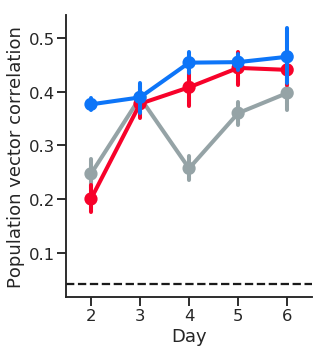

In [23]:
fig = plt.figure(figsize=(6,5))

g = sns.catplot(x='day',y="value", hue='grp',
                kind="point",data=df,ci=68)

# axisjpegmadia
g.set(xlabel='Day', ylabel=key_label)
sns.despine()

# legend
g._legend.remove()

# shuffle
g.ax.axhline(df_shuffle.value.mean(), linestyle='--', color='k')

# save
#g.savefig('figs/popvec-by-day-dpair.svg')

In [20]:
%%R -i df
library(nlme)

am2 <- with(df, lme(value ~ grp * day,random = ~1|mouseID))
print(anova(am2))
#summary(am2)

            numDF denDF  F-value p-value
(Intercept)     1   183 338.6233  <.0001
grp             2    13   1.0660  0.3726
day             4   183  16.8247  <.0001
grp:day         8   183   3.8676  0.0003


In [31]:
%%R -i df
am2 <-aov(value ~ (grp*day) + Error(mouseID/(day)), data = df)
print(summary(am2))



Error: mouseID
          Df Sum Sq Mean Sq F value Pr(>F)  
grp        2 0.2659 0.13297   6.546 0.0402 *
day        4 0.7340 0.18349   9.033 0.0165 *
grp:day    4 0.1990 0.04976   2.450 0.1762  
Residuals  5 0.1016 0.02031                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: mouseID:day
          Df Sum Sq Mean Sq F value   Pr(>F)    
day        4 0.6982 0.17456   9.262 1.25e-05 ***
grp:day    8 0.3237 0.04046   2.147   0.0491 *  
Residuals 48 0.9047 0.01885                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq  Mean Sq F value Pr(>F)
Residuals 135  1.017 0.007532               


In [20]:
for n,g in df.groupby("day"):
    
    print(n)
    g = just_day(g)
    stats.full_anova(g,ind_vars=['grp'],dep_var='value')

2
# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.342   
Dependent Variable: value            AIC:                -64.2275
Date:               2020-01-07 12:37 BIC:                -58.9439
No. Observations:   43               Log-Likelihood:     35.114  
Df Model:           2                F-statistic:        11.94   
Df Residuals:       40               Prob (F-statistic): 8.61e-05
R-squared:          0.374            Scale:              0.012293
-----------------------------------------------------------------
                     Coef.  Std.Err.   t    P>|t|   [0.025 0.975]
-----------------------------------------------------------------
Intercept            0.2142   0.0261 8.1968 0.0000  0.1614 0.2670
C(grp)[T.Control]    0.0696   0.0395 1.7609 0.0859 -0.0103 0.1494
C(grp)[T.dn-CREB]    0.2070   0.0424 4.8796 0.0000  0.1213 0.2928
-----------------------

## ratio

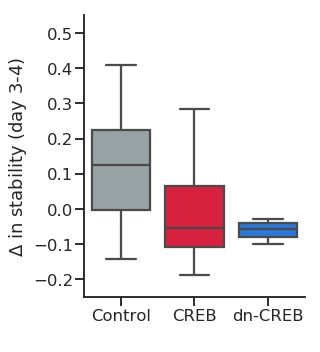

In [12]:
dfm = calc_day_diff(df_mid)

height,width = 5., 4.5

g = sns.catplot(x='grp',y="diff",
                kind="box",data=dfm,showfliers=False,
                height=height, aspect=width/height)

# axis
g.set(ylim=(-.25,.55),ylabel=r'$\Delta$ in stability (day 3-4)',xlabel=' ')
sns.despine()

# legend


# save
#g.savefig('figs/popvec-delta34-dpair-pcboth.svg')

In [240]:
stats.full_anova(dfm,ind_vars=['grp'],dep_var='diff')

# Formula: diff~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.251   
Dependent Variable: diff             AIC:                -50.2061
Date:               2019-08-14 00:23 BIC:                -45.0653
No. Observations:   41               Log-Likelihood:     28.103  
Df Model:           2                F-statistic:        7.698   
Df Residuals:       38               Prob (F-statistic): 0.00156 
R-squared:          0.288            Scale:              0.016038
-----------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
-----------------------------------------------------------------
Intercept          -0.0199   0.0317 -0.6287 0.5333 -0.0840 0.0442
C(grp)[T.Control]   0.1435   0.0473  3.0348 0.0043  0.0478 0.2392
C(grp)[T.dn-CREB]  -0.0438   0.0484 -0.9054 0.3710 -0.1417 0.0541
--------------------------

##  same v diff (supplement)

                index  position_bin_index  value  grp  pairing  trial_id  \
day reward_loc                                                             
2   Same           43                  43     43   43       43        43   
3   Same           43                  43     43   43       43        43   
4   Different      44                  44     44   44       44        44   
5   Same           41                  41     41   41       41        41   
6   Same           39                  39     39   39       39        39   

                condition  session  experimentType  startTime  mouseID  \
day reward_loc                                                           
2   Same               43       43              43         43       43   
3   Same               43       43              43         43       43   
4   Different          44       44              44         44       44   
5   Same               41       41              41         41       41   
6   Same               

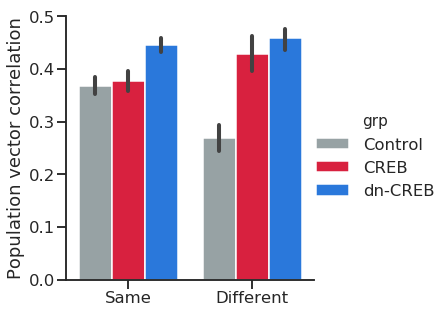

In [82]:
df = add_same_diff_cols(df)

ax = sns.catplot(x='reward_loc',y="value", hue='grp',
                kind="bar",data=df,ci=68)
    
ax.set(xlabel='', ylabel=key_label)
sns.despine()

In [83]:
%%R -i df
am2 <-aov(value ~ grp*reward_loc, data = df)

print(summary(am2))
#TukeyHSD(am2)

                Df Sum Sq Mean Sq F value   Pr(>F)    
grp              2  0.336 0.16788  10.223 5.87e-05 ***
reward_loc       1  0.003 0.00319   0.195   0.6596    
grp:reward_loc   2  0.140 0.07023   4.277   0.0152 *  
Residuals      204  3.350 0.01642                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ grp * reward_loc, data = df)

$grp
                      diff         lwr        upr     p adj
CREB-Control    0.03980368 -0.01009941 0.08970676 0.1461648
dn-CREB-Control 0.10121008  0.04808282 0.15433733 0.0000342
dn-CREB-CREB    0.06140640  0.01021473 0.11259808 0.0140351

$reward_loc
                      diff         lwr        upr    p adj
Same-Different 0.009580333 -0.03326179 0.05242246 0.659751

$`grp:reward_loc`
                                            diff           lwr        upr
CREB:Different-Control:Different     0.158938893  0.0240

In [99]:
for n,g in df.groupby("reward_loc"):
    
    print('**************{}***************'.format(n))
    print('')
    g = just_day(g)
    stats.full_anova(g, ind_vars=['grp','reward_loc'], dep_var='value')
    print('')

**************Different***************

# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.329   
Dependent Variable: value            AIC:                -64.4669
Date:               2019-08-13 12:05 BIC:                -59.1143
No. Observations:   44               Log-Likelihood:     35.233  
Df Model:           2                F-statistic:        11.56   
Df Residuals:       41               Prob (F-statistic): 0.000104
R-squared:          0.361            Scale:              0.012667
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.4278   0.0281 15.2055 0.0000  0.3710  0.4847
C(grp)[T.Control] -0.1589   0.0412 -3.8589 0.0004 -0.2421 -0.0758
C(grp)[T.dn-CREB]  0.0303   0.0412  0.7365 0.4656 -

# Just 3 v 4 (probably don't need)

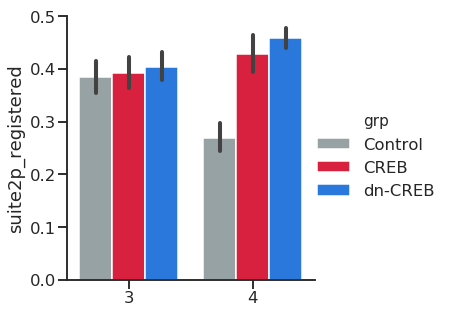

In [192]:
df_mid = just_day(df.loc[df["day"].isin(['3','4'])])

ax = sns.catplot(x='day',y="value", hue='grp',
                kind="bar",data=df_mid,ci=68)
    
ax.set(xlabel='', ylabel=label)
sns.despine()

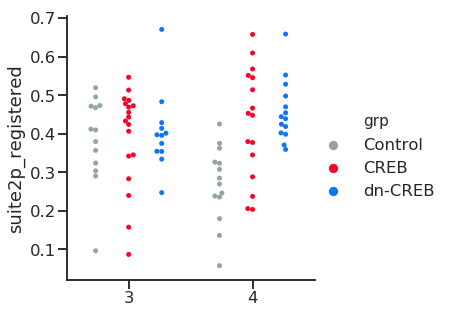

In [88]:
ax = sns.catplot(x='day',y="value", hue='grp',
                kind="swarm",dodge=True,data=df_mid,ci=68)
    
ax.set(xlabel='', ylabel=label)
sns.despine()

In [90]:
%%R -i df_mid
am2 <-aov(value ~ (grp*day) + Error(mouseID/(day)), data = df_mid)

#for label,df in all_dfs.items()
print(summary(am2))


Error: mouseID
          Df  Sum Sq Mean Sq F value Pr(>F)  
grp        2 0.17730 0.08865   4.007 0.0527 .
day        1 0.00557 0.00557   0.252 0.6267  
grp:day    2 0.26033 0.13016   5.883 0.0205 *
Residuals 10 0.22124 0.02212                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: mouseID:day
          Df Sum Sq Mean Sq F value Pr(>F)  
day        1 0.0017 0.00170   0.193 0.6681  
grp:day    2 0.1082 0.05409   6.131 0.0146 *
Residuals 12 0.1059 0.00882                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
          Df Sum Sq  Mean Sq F value Pr(>F)
Residuals 56 0.4801 0.008574               


# PF correlation

## key select

In [13]:
key = 'pf_correlation'
key_label = 'Place field correlation'

# select key
df = deepcopy(all_dfs[key])
df,df_shuffle = just_day(df,shuffle=True)

# just day 3/4
df_mid = just_day(df.loc[df["day"].isin(['3','4'])])


## overall

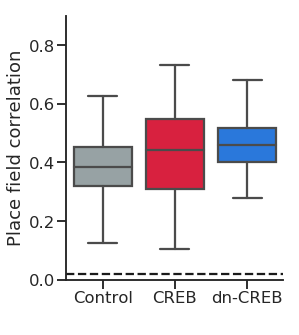

In [317]:
height,width = 5., 4.5
#fig = plt.figure(figsize=(2,5))
#ax = sns.boxplot(x="grp",y="value",data=df,showfliers=False)

g = sns.catplot(x='grp',y="value",
                kind="box",data=df,showfliers=False,
                height=height, aspect=width/height)

# axis
g.set(ylim=(0,.9),ylabel=key_label,xlabel=' ')
sns.despine()

# legend


# shuffle
g.ax.axhline(df_shuffle.value.mean(), linestyle='--', color='k')

# save
g.savefig('figs/pfcorr-overall-dpair-pcboth.svg')

In [27]:
%%R -i df
am2 <-aov(value ~ grp, data = df)

print(summary(am2))
TukeyHSD(am2)

             Df Sum Sq Mean Sq F value  Pr(>F)   
grp           2  0.266 0.13297   6.953 0.00119 **
Residuals   208  3.978 0.01912                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ grp, data = df)

$grp
                      diff          lwr        upr     p adj
CREB-Control    0.03980368 -0.014042552 0.09364991 0.1910482
dn-CREB-Control 0.09007536  0.032988683 0.14716205 0.0007339
dn-CREB-CREB    0.05027169 -0.004717415 0.10526079 0.0809680



In [280]:
%%R -i df
am2 <-aov(value ~ grp, data = df)

print(summary(am2))
TukeyHSD(am2)

             Df Sum Sq Mean Sq F value  Pr(>F)   
grp           2  0.244  0.1218   6.481 0.00186 **
Residuals   207  3.891  0.0188                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ grp, data = df)

$grp
                      diff         lwr        upr     p adj
CREB-Control    0.04334619 -0.01003738 0.09672976 0.1364801
dn-CREB-Control 0.08663707  0.02980446 0.14346968 0.0011604
dn-CREB-CREB    0.04329087 -0.01147115 0.09805290 0.1511681



In [281]:
stats.full_anova(df,ind_vars=['grp'],dep_var='value')

# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.050    
Dependent Variable: value            AIC:                -235.6277
Date:               2019-08-14 17:08 BIC:                -225.5863
No. Observations:   210              Log-Likelihood:     120.81   
Df Model:           2                F-statistic:        6.481    
Df Residuals:       207              Prob (F-statistic): 0.00186  
R-squared:          0.059            Scale:              0.018796 
------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
------------------------------------------------------------------
Intercept            0.4193   0.0153 27.3555 0.0000  0.3891 0.4495
C(grp)[T.Control]   -0.0433   0.0226 -1.9168 0.0566 -0.0879 0.0012
C(grp)[T.dn-CREB]    0.0433   0.0232  1.8662 0.0634 -0.0024 0.0890
-----------

## By day

<Figure size 432x360 with 0 Axes>

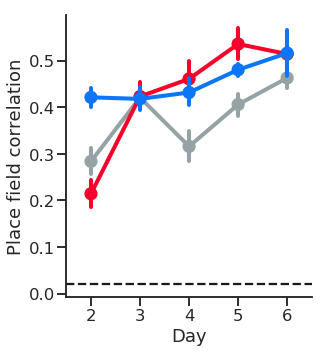

In [15]:
fig = plt.figure(figsize=(6,5))

g = sns.catplot(x='day',y="value", hue='grp',
                kind="point",data=df,ci=68)

# axisjpegmadia
g.set(xlabel='Day', ylabel=key_label)
sns.despine()

# legend
g._legend.remove()

# shuffle
g.ax.axhline(df_shuffle.value.mean(), linestyle='--', color='k')

# save
g.savefig('figs/pfcorr-by-day-dpair.svg')


#### two different stats approaches
Take a look at the two test below. nlme seems to agg by mouse, and aov lets session be present. dunno which is more valid, but probably going with aov

In [16]:
%%R -i df
library(nlme)

am2 <- with(df, lme(value ~ grp * day,random = ~1|mouseID))
print(anova(am2))
#summary(am2)

            numDF denDF   F-value p-value
(Intercept)     1   183 307.77148  <.0001
grp             2    13   0.49261   0.622
day             4   183  26.28233  <.0001
grp:day         8   183   4.56728  <.0001


In [17]:
%%R -i df
am2 <-aov(value ~ (grp*day) + Error(mouseID/(day)), data = df)
print(summary(am2))


Error: mouseID
          Df Sum Sq Mean Sq F value Pr(>F)  
grp        2 0.2046 0.10230   3.389 0.1174  
day        4 0.9874 0.24684   8.178 0.0203 *
grp:day    4 0.0822 0.02055   0.681 0.6345  
Residuals  5 0.1509 0.03018                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: mouseID:day
          Df Sum Sq Mean Sq F value   Pr(>F)    
day        4 0.9388 0.23470  17.834 4.93e-09 ***
grp:day    8 0.3219 0.04024   3.058  0.00731 ** 
Residuals 48 0.6317 0.01316                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq  Mean Sq F value Pr(>F)
Residuals 135  1.017 0.007533               


In [285]:
for n,g in df.groupby("day"):
    
    print(n)
    g = just_day(g)
    stats.full_anova(g,ind_vars=['grp'],dep_var='value')

2
# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.342   
Dependent Variable: value            AIC:                -64.2275
Date:               2019-08-14 17:09 BIC:                -58.9439
No. Observations:   43               Log-Likelihood:     35.114  
Df Model:           2                F-statistic:        11.94   
Df Residuals:       40               Prob (F-statistic): 8.61e-05
R-squared:          0.374            Scale:              0.012293
-----------------------------------------------------------------
                     Coef.  Std.Err.   t    P>|t|   [0.025 0.975]
-----------------------------------------------------------------
Intercept            0.2142   0.0261 8.1968 0.0000  0.1614 0.2670
C(grp)[T.Control]    0.0696   0.0395 1.7609 0.0859 -0.0103 0.1494
C(grp)[T.dn-CREB]    0.2070   0.0424 4.8796 0.0000  0.1213 0.2928
-----------------------

## ratio

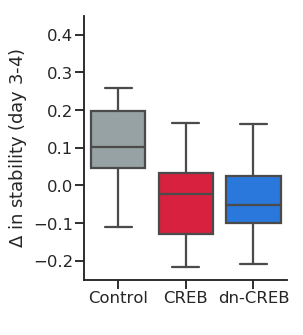

In [299]:
dfm = calc_day_diff(df_mid)

height,width = 5., 4.5

g = sns.catplot(x='grp',y="diff",
                kind="box",data=dfm,showfliers=False,
                height=height, aspect=width/height)

# axis
g.set(ylim=(-.25,.45),ylabel=r'$\Delta$ in stability (day 3-4)',xlabel=' ')
sns.despine()

# legend


# save
g.savefig('figs/pfcorr-delta34-dpair-pcboth.svg')

In [292]:
stats.full_anova(dfm,ind_vars=['grp'],dep_var='diff')

# Formula: diff~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.167   
Dependent Variable: diff             AIC:                -52.9941
Date:               2019-08-14 17:13 BIC:                -47.8534
No. Observations:   41               Log-Likelihood:     29.497  
Df Model:           2                F-statistic:        5.002   
Df Residuals:       38               Prob (F-statistic): 0.0118  
R-squared:          0.208            Scale:              0.014984
-----------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
-----------------------------------------------------------------
Intercept          -0.0227   0.0306 -0.7422 0.4625 -0.0847 0.0392
C(grp)[T.Control]   0.1218   0.0457  2.6657 0.0112  0.0293 0.2144
C(grp)[T.dn-CREB]  -0.0169   0.0467 -0.3617 0.7196 -0.1115 0.0777
--------------------------

##  same v diff (supplement)

                index  position_bin_index  value  grp  pairing  trial_id  \
day reward_loc                                                             
2   Same           43                  43     43   43       43        43   
3   Same           43                  43     43   43       43        43   
4   Different      44                  44     44   44       44        44   
5   Same           41                  41     41   41       41        41   
6   Same           39                  39     39   39       39        39   

                condition  session  experimentType  startTime  mouseID  \
day reward_loc                                                           
2   Same               43       43              43         43       43   
3   Same               43       43              43         43       43   
4   Different          44       44              44         44       44   
5   Same               41       41              41         41       41   
6   Same               

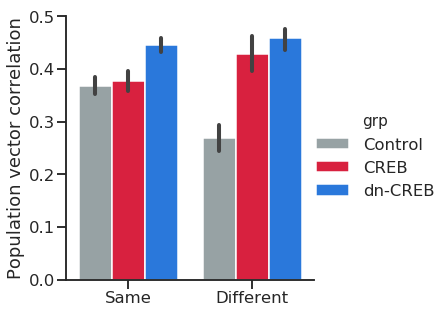

In [82]:
df_mid = just_day(df.loc[df["day"].isin(['3','4'])])
df = add_same_diff_cols(df)

ax = sns.catplot(x='reward_loc',y="value", hue='grp',
                kind="bar",data=df,ci=68)
    
ax.set(xlabel='', ylabel=key_label)
sns.despine()

In [83]:
%%R -i df
am2 <-aov(value ~ grp*reward_loc, data = df)

print(summary(am2))
#TukeyHSD(am2)

                Df Sum Sq Mean Sq F value   Pr(>F)    
grp              2  0.336 0.16788  10.223 5.87e-05 ***
reward_loc       1  0.003 0.00319   0.195   0.6596    
grp:reward_loc   2  0.140 0.07023   4.277   0.0152 *  
Residuals      204  3.350 0.01642                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ grp * reward_loc, data = df)

$grp
                      diff         lwr        upr     p adj
CREB-Control    0.03980368 -0.01009941 0.08970676 0.1461648
dn-CREB-Control 0.10121008  0.04808282 0.15433733 0.0000342
dn-CREB-CREB    0.06140640  0.01021473 0.11259808 0.0140351

$reward_loc
                      diff         lwr        upr    p adj
Same-Different 0.009580333 -0.03326179 0.05242246 0.659751

$`grp:reward_loc`
                                            diff           lwr        upr
CREB:Different-Control:Different     0.158938893  0.0240

In [99]:
for n,g in df.groupby("reward_loc"):
    
    print('**************{}***************'.format(n))
    print('')
    g = just_day(g)
    stats.full_anova(g, ind_vars=['grp','reward_loc'], dep_var='value')
    print('')

**************Different***************

# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.329   
Dependent Variable: value            AIC:                -64.4669
Date:               2019-08-13 12:05 BIC:                -59.1143
No. Observations:   44               Log-Likelihood:     35.233  
Df Model:           2                F-statistic:        11.56   
Df Residuals:       41               Prob (F-statistic): 0.000104
R-squared:          0.361            Scale:              0.012667
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.4278   0.0281 15.2055 0.0000  0.3710  0.4847
C(grp)[T.Control] -0.1589   0.0412 -3.8589 0.0004 -0.2421 -0.0758
C(grp)[T.dn-CREB]  0.0303   0.0412  0.7365 0.4656 -

# Reccurence prob

## key select

In [36]:
all_dfs.keys()

['recurrence', 'pf_correlation', 'pop_vector', 'centroid_shift']

In [37]:
key = 'recurrence'
key_label = 'Recurrence probability'

# select key
df = deepcopy(all_dfs[key])
df,df_shuffle = just_day(df,shuffle=True)

# just day 3/4
df_mid = just_day(df.loc[df["day"].isin(['3','4'])])


## overall

In [39]:
df.columns

Index([u'index', u'grp', u'num_pcs_first_expt', u'num_pcs_second_expt',
       u'num_recur', u'num_shared_rois', u'value', u'pairing', u'trial_id',
       u'condition', u'day', u'session', u'experimentType', u'startTime',
       u'mouseID', u'session_day'],
      dtype='object')

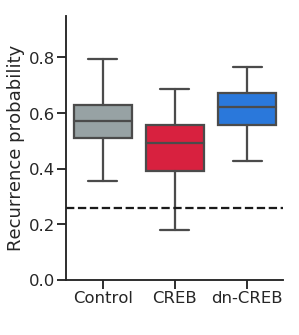

In [323]:
height,width = 5., 4.5
#fig = plt.figure(figsize=(2,5))
#ax = sns.boxplot(x="grp",y="value",data=df,showfliers=False)

g = sns.catplot(x='grp',y="value",
                kind="box",data=df,showfliers=False,
                height=height, aspect=width/height)

# axis
g.set(ylim=(0,.95),ylabel=key_label,xlabel=' ') # ylim=(0,.9)
sns.despine()

# legend


# shuffle
g.ax.axhline(df_shuffle.value.mean(), linestyle='--', color='k')

# save
#g.savefig('figs/recurr-overall-dpair-pcboth.svg')

In [320]:
%%R -i df
am2 <-aov(value ~ grp, data = df)

print(summary(am2))
TukeyHSD(am2)

             Df Sum Sq Mean Sq F value   Pr(>F)    
grp           2 0.6254 0.31268   22.77 1.14e-09 ***
Residuals   208 2.8566 0.01373                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ grp, data = df)

$grp
                       diff          lwr         upr     p adj
CREB-Control    -0.08132900 -0.126779696 -0.03587830 0.0001060
dn-CREB-Control  0.04953518  0.001125495  0.09794486 0.0435807
dn-CREB-CREB     0.13086417  0.084056149  0.17767220 0.0000000



In [321]:
stats.full_anova(df,ind_vars=['grp'],dep_var='value')

# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.172    
Dependent Variable: value            AIC:                -302.9788
Date:               2019-08-15 20:10 BIC:                -292.9232
No. Observations:   211              Log-Likelihood:     154.49   
Df Model:           2                F-statistic:        22.77    
Df Residuals:       208              Prob (F-statistic): 1.14e-09 
R-squared:          0.180            Scale:              0.013734 
------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|  [0.025 0.975]
------------------------------------------------------------------
Intercept             0.4747   0.0131 36.2269 0.0000 0.4488 0.5005
C(grp)[T.Control]     0.0813   0.0193  4.2241 0.0000 0.0434 0.1193
C(grp)[T.dn-CREB]     0.1309   0.0198  6.5997 0.0000 0.0918 0.1700
-----------

## By day

<Figure size 432x360 with 0 Axes>

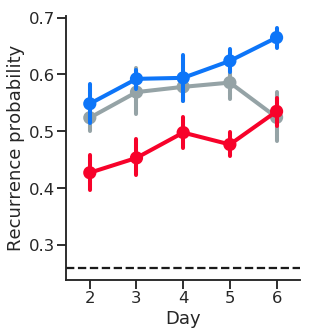

In [324]:
fig = plt.figure(figsize=(6,5))

g = sns.catplot(x='day',y="value", hue='grp',
                kind="point",data=df,ci=68)

# axisjpegmadia
g.set(xlabel='Day', ylabel=key_label)
sns.despine()

# legend
g._legend.remove()

# shuffle
g.ax.axhline(df_shuffle.value.mean(), linestyle='--', color='k')

# save
#g.savefig('figs/recurr-by-day-dpair.svg')

In [49]:
%%R -i df
am2 <-aov(value ~ (grp*day) + Error(mouseID/(day)), data = df)
print(summary(am2))


Error: mouseID
          Df Sum Sq Mean Sq F value Pr(>F)  
grp        2 0.5648 0.28241   9.422 0.0141 *
day        4 0.7222 0.18055   6.024 0.0270 *
grp:day    3 0.3237 0.10790   3.600 0.0852 .
Residuals  6 0.1798 0.02997                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: mouseID:day
          Df Sum Sq Mean Sq F value Pr(>F)  
day        4 0.1436 0.03589   2.689 0.0421 *
grp:day    8 0.0698 0.00872   0.653 0.7290  
Residuals 48 0.6407 0.01335                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq  Mean Sq F value Pr(>F)
Residuals 136  1.041 0.007652               


In [47]:
for n,g in df.groupby("day"):
    
    print(n)
    g = just_day(g)
    stats.full_anova(g,ind_vars=['grp'],dep_var='value')

2
# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.153   
Dependent Variable: value            AIC:                -61.8811
Date:               2020-01-05 16:59 BIC:                -56.5975
No. Observations:   43               Log-Likelihood:     33.941  
Df Model:           2                F-statistic:        4.807   
Df Residuals:       40               Prob (F-statistic): 0.0135  
R-squared:          0.194            Scale:              0.012982
-----------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|  [0.025 0.975]
-----------------------------------------------------------------
Intercept            0.4271   0.0269 15.9028 0.0000 0.3728 0.4814
C(grp)[T.Control]    0.0967   0.0406  2.3817 0.0221 0.0146 0.1788
C(grp)[T.dn-CREB]    0.1214   0.0436  2.7833 0.0082 0.0332 0.2095
-----------------------

In [285]:
for n,g in df.groupby("day"):
    
    print(n)
    g = just_day(g)
    stats.full_anova(g,ind_vars=['grp'],dep_var='value')

2
# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.342   
Dependent Variable: value            AIC:                -64.2275
Date:               2019-08-14 17:09 BIC:                -58.9439
No. Observations:   43               Log-Likelihood:     35.114  
Df Model:           2                F-statistic:        11.94   
Df Residuals:       40               Prob (F-statistic): 8.61e-05
R-squared:          0.374            Scale:              0.012293
-----------------------------------------------------------------
                     Coef.  Std.Err.   t    P>|t|   [0.025 0.975]
-----------------------------------------------------------------
Intercept            0.2142   0.0261 8.1968 0.0000  0.1614 0.2670
C(grp)[T.Control]    0.0696   0.0395 1.7609 0.0859 -0.0103 0.1494
C(grp)[T.dn-CREB]    0.2070   0.0424 4.8796 0.0000  0.1213 0.2928
-----------------------

# Centroid shift

## key select

In [300]:
all_dfs.keys()

['recurrence', 'pf_correlation', 'pop_vector', 'centroid_shift']

In [312]:
key = 'centroid_shift'
key_label = 'Centroid shift (cm of belt)'

# select key
df = deepcopy(all_dfs[key])
df,df_shuffle = just_day(df,shuffle=True)

# just day 3/4
df_mid = just_day(df.loc[df["day"].isin(['3','4'])])


## overall

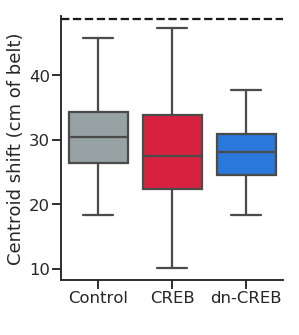

In [313]:
height,width = 5., 4.5
#fig = plt.figure(figsize=(2,5))
#ax = sns.boxplot(x="grp",y="value",data=df,showfliers=False)

g = sns.catplot(x='grp',y="value",
                kind="box",data=df,showfliers=False,
                height=height, aspect=width/height)

# axis
g.set(ylabel=key_label,xlabel=' ') # ylim=(0,.9)
sns.despine()

# legend


# shuffle
g.ax.axhline(df_shuffle.value.mean(), linestyle='--', color='k')

# save
g.savefig('figs/shift-overall-dpair-pcboth.svg')

In [307]:
%%R -i df
am2 <-aov(value ~ grp, data = df)

print(summary(am2))
TukeyHSD(am2)

             Df Sum Sq Mean Sq F value Pr(>F)  
grp           2    331  165.50   2.762 0.0655 .
Residuals   207  12404   59.92                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ grp, data = df)

$grp
                      diff       lwr       upr     p adj
CREB-Control    -2.1570463 -5.171221 0.8571288 0.2116715
dn-CREB-Control -3.0794251 -6.288342 0.1294916 0.0630341
dn-CREB-CREB    -0.9223789 -4.014385 2.1696277 0.7612658



In [308]:
stats.full_anova(df,ind_vars=['grp'],dep_var='value')

# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.017    
Dependent Variable: value            AIC:                1458.4753
Date:               2019-08-15 10:15 BIC:                1468.5166
No. Observations:   210              Log-Likelihood:     -726.24  
Df Model:           2                F-statistic:        2.762    
Df Residuals:       207              Prob (F-statistic): 0.0655   
R-squared:          0.026            Scale:              59.923   
------------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept          28.6979   0.8655 33.1587 0.0000 26.9916 30.4042
C(grp)[T.Control]   2.1570   1.2768  1.6894 0.0926 -0.3602  4.6743
C(grp)[T.dn-CREB]  -0.9224   1.3098 -0.7042 0.4821 -3.5046  1.6599
-----------

## By day

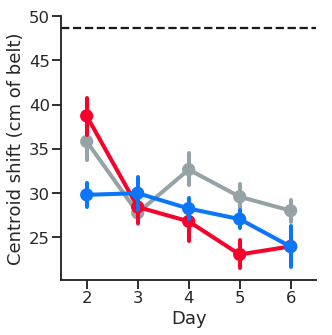

In [314]:
g = sns.catplot(x='day',y="value", hue='grp',
                kind="point",data=df,ci=68)

# axisjpegmadia
g.set(xlabel='Day', ylabel=key_label)
sns.despine()

# legend
g._legend.remove()

# shuffle
g.ax.axhline(df_shuffle.value.mean(), linestyle='--', color='k')

# save
g.savefig('figs/shift-by-day-dpair.svg')

In [310]:
%%R -i df
library(nlme)

am2 <- with(df, lme(value ~ grp * day,random = ~1|mouseID))
print(anova(am2))
#summary(am2)

            numDF denDF  F-value p-value
(Intercept)     1   182 743.5998  <.0001
grp             2    13   0.7698  0.4831
day             4   182  15.6018  <.0001
grp:day         8   182   2.7938  0.0061


In [311]:
for n,g in df.groupby("day"):
    
    print(n)
    g = just_day(g)
    stats.full_anova(g,ind_vars=['grp'],dep_var='value')

2
# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                  Results: Ordinary least squares
Model:               OLS              Adj. R-squared:     0.136   
Dependent Variable:  value            AIC:                303.4467
Date:                2019-08-15 10:15 BIC:                308.7303
No. Observations:    43               Log-Likelihood:     -148.72 
Df Model:            2                F-statistic:        4.302   
Df Residuals:        40               Prob (F-statistic): 0.0203  
R-squared:           0.177            Scale:              63.549  
------------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025   0.975]
------------------------------------------------------------------
Intercept         38.7302   1.8790 20.6126 0.0000  34.9327 42.5277
C(grp)[T.Control] -2.8941   2.8407 -1.0188 0.3144  -8.6354  2.8472
C(grp)[T.dn-CREB] -8.9303   3.0508 -2.9272 0.0056 -15.0963 -2.7643
---------

# Multi plot all measures

## overall

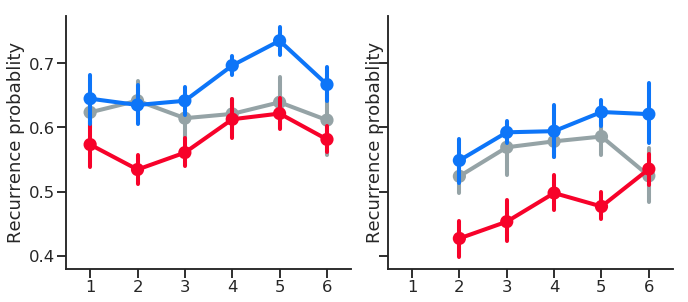

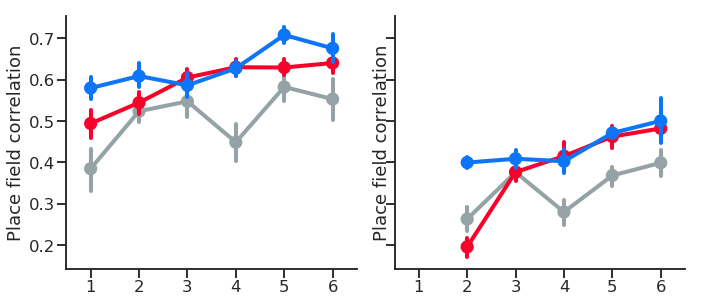

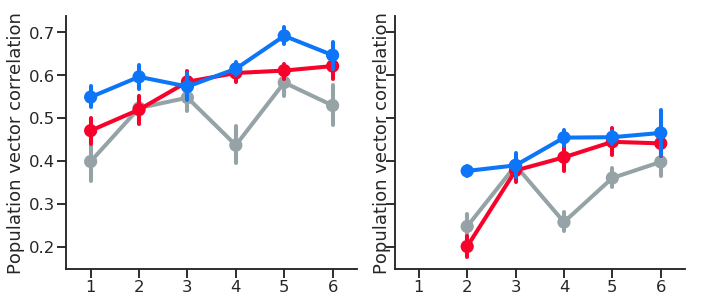

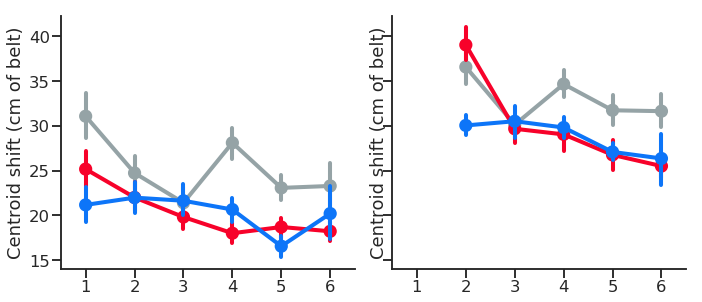

In [47]:
for key,df in all_dfs.items():

    ax = sns.catplot(x='day',col="pairing",y="value", hue='grp',
                kind="point",data=df[df.grp !='shuffle'],ci=68)
    
    ax._legend.remove()
    ax.set(xlabel='', ylabel=activity_labels[key],title="")
    sns.despine()
    
    ax.savefig('figs/F13-stability-extended-pc-either-{}.svg'.format(key))

## All stats

In [62]:
# day stats 
for label,df in all_dfs.items():
    
    df = just_session(df)
    
    print('\n')
    print("===" + label + "====")
    %Rpush df    
    %R am2 <-aov(value ~ (grp*day) + Error(mouseID/(day)), data = df)
    %R print(summary(am2))



===recurrence====



Error: mouseID
          Df Sum Sq Mean Sq F value Pr(>F)  
grp        2 0.3467 0.17334   6.315 0.0334 *
day        5 0.2601 0.05201   1.895 0.2294  
grp:day    2 0.1392 0.06958   2.535 0.1592  
Residuals  6 0.1647 0.02745                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: mouseID:day
          Df Sum Sq  Mean Sq F value Pr(>F)  
day        5 0.1009 0.020174   2.162 0.0704 .
grp:day   10 0.0519 0.005191   0.556 0.8422  
Residuals 59 0.5504 0.009329                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq Mean Sq F value Pr(>F)
Residuals 149   1.72 0.01154               




===pf_correlation====



Error: mouseID
          Df Sum Sq Mean Sq F value  Pr(>F)   
grp        2 0.5946 0.29732   15.77 0.00408 **
day        5 0.7240 0.14479    7.68 0.01380 * 
grp:day    2 0.1335 0.06675    3.54 0.09650 . 
Residuals  6 0.1131 0.01885                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: mouseID:day
          Df Sum Sq Mean Sq F value   Pr(>F)    
day        5 0.4690 0.09381  10.279 4.05e-07 ***
grp:day   10 0.1764 0.01764   1.933   0.0582 .  
Residuals 59 0.5385 0.00913                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq Mean Sq F value Pr(>F)
Residuals 149  1.711 0.01148               




===pop_vector====



Error: mouseID
          Df Sum Sq Mean Sq F value   Pr(>F)    
grp        2 0.4561 0.22807  32.499 0.000604 ***
day        5 0.7995 0.15989  22.784 0.000776 ***
grp:day    2 0.1050 0.05252   7.483 0.023435 *  
Residuals  6 0.0421 0.00702                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: mouseID:day
          Df Sum Sq Mean Sq F value   Pr(>F)    
day        5 0.4302 0.08604  10.218 4.37e-07 ***
grp:day   10 0.1783 0.01783   2.117    0.037 *  
Residuals 59 0.4968 0.00842                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq Mean Sq F value Pr(>F)
Residuals 149  1.808 0.01213               




===centroid_shift====



Error: mouseID
          Df Sum Sq Mean Sq F value Pr(>F)  
grp        2 1225.8   612.9   8.010 0.0202 *
day        5 1886.4   377.3   4.931 0.0388 *
grp:day    2  364.5   182.2   2.382 0.1732  
Residuals  6  459.1    76.5                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: mouseID:day
          Df Sum Sq Mean Sq F value  Pr(>F)   
day        5  748.8  149.76   3.810 0.00467 **
grp:day   10  535.5   53.55   1.362 0.22038   
Residuals 59 2319.3   39.31                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq Mean Sq F value Pr(>F)
Residuals 149   5487   36.82               


In [61]:
# day stats 
for label,df in all_dfs.items():
    
    df = just_day(df)
    
    print('\n')
    print("===" + label + "====")
    %Rpush df    
    %R am2 <-aov(value ~ (grp*day) + Error(mouseID/(day)), data = df)
    %R print(summary(am2))



===recurrence====



Error: mouseID
          Df Sum Sq Mean Sq F value Pr(>F)  
grp        2 0.5648 0.28241   9.422 0.0141 *
day        4 0.7222 0.18055   6.024 0.0270 *
grp:day    3 0.3237 0.10790   3.600 0.0852 .
Residuals  6 0.1798 0.02997                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: mouseID:day
          Df Sum Sq Mean Sq F value Pr(>F)  
day        4 0.1436 0.03589   2.689 0.0421 *
grp:day    8 0.0698 0.00872   0.653 0.7290  
Residuals 48 0.6407 0.01335                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq  Mean Sq F value Pr(>F)
Residuals 136  1.041 0.007652               




===pf_correlation====



Error: mouseID
          Df Sum Sq Mean Sq F value Pr(>F)  
grp        2 0.3383 0.16916   5.862 0.0388 *
day        4 0.6766 0.16915   5.862 0.0287 *
grp:day    3 0.1958 0.06526   2.262 0.1816  
Residuals  6 0.1731 0.02886                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: mouseID:day
          Df Sum Sq Mean Sq F value   Pr(>F)    
day        4 0.7785 0.19462  16.330 1.65e-08 ***
grp:day    8 0.2306 0.02882   2.419   0.0278 *  
Residuals 48 0.5720 0.01192                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq  Mean Sq F value Pr(>F)
Residuals 136 0.9198 0.006764               




===pop_vector====



Error: mouseID
          Df Sum Sq Mean Sq F value Pr(>F)  
grp        2 0.3447 0.17233   8.306 0.0187 *
day        4 0.5520 0.13799   6.651 0.0215 *
grp:day    3 0.2009 0.06695   3.227 0.1033  
Residuals  6 0.1245 0.02075                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: mouseID:day
          Df Sum Sq Mean Sq F value   Pr(>F)    
day        4 0.6691 0.16728  11.222 1.66e-06 ***
grp:day    8 0.2688 0.03360   2.254   0.0393 *  
Residuals 48 0.7155 0.01491                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq  Mean Sq F value Pr(>F)
Residuals 136  1.019 0.007493               




===centroid_shift====



Error: mouseID
          Df Sum Sq Mean Sq F value Pr(>F)  
grp        2  617.8   308.9   2.847  0.135  
day        4 1653.9   413.5   3.811  0.071 .
grp:day    3  640.5   213.5   1.968  0.220  
Residuals  6  650.9   108.5                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: mouseID:day
          Df Sum Sq Mean Sq F value   Pr(>F)    
day        4 1372.8   343.2   7.236 0.000121 ***
grp:day    8  577.9    72.2   1.523 0.174308    
Residuals 48 2276.6    47.4                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq Mean Sq F value Pr(>F)
Residuals 136   3696   27.17               


### follow up one ways

In [31]:
key = 'pop_vector'
key_label = 'Centroid shift (cm of belt)'

# select key
df = deepcopy(all_dfs[key])


for n,g in df.groupby("day"):
    
    print(n)
    g = just_session(g)
    stats.full_anova(g,ind_vars=['grp'],dep_var='value')

1
# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.150   
Dependent Variable: value            AIC:                -39.6778
Date:               2020-02-12 17:18 BIC:                -35.5759
No. Observations:   29               Log-Likelihood:     22.839  
Df Model:           2                F-statistic:        3.465   
Df Residuals:       26               Prob (F-statistic): 0.0464  
R-squared:          0.210            Scale:              0.013517
-----------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
-----------------------------------------------------------------
Intercept           0.4704   0.0336 14.0162 0.0000  0.4014 0.5394
C(grp)[T.Control]  -0.0720   0.0498 -1.4458 0.1602 -0.1743 0.0304
C(grp)[T.dn-CREB]   0.0783   0.0553  1.4155 0.1688 -0.0354 0.1919
-----------------------

### overall

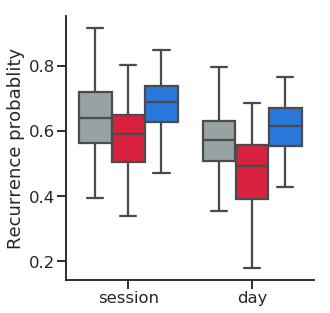

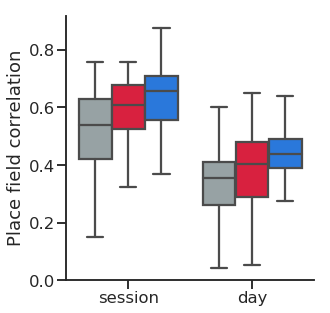

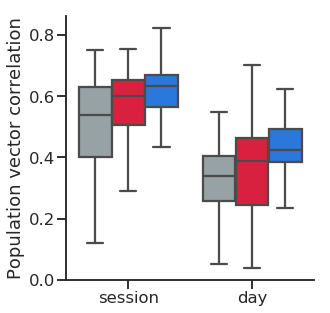

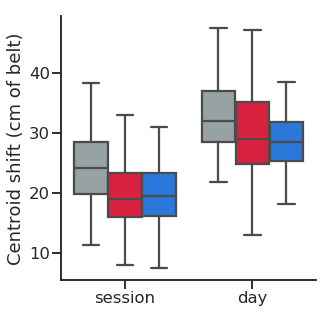

In [48]:
for key,df in all_dfs.items():

    ax = sns.catplot(x='pairing',y="value", hue='grp',
                kind="box",data=df[df.grp !='shuffle'],ci=68,showfliers=False)
    
    ax._legend.remove()
    ax.set(xlabel='', ylabel=activity_labels[key],title="")
    sns.despine()
    
    
    ax.savefig('figs/F13-stability-extended-pc-either-boxes-{}.svg'.format(key))

In [56]:
for label,df in all_dfs.items():

    df = rm_shuffle(df)
    
    print(label)
    %Rpush df
    %R am2 <-aov(value ~ pairing * grp, data = df)
    %R print(summary(am2))

recurrence


             Df Sum Sq Mean Sq F value   Pr(>F)    
pairing       1  0.775  0.7750  56.465 3.17e-13 ***
grp           2  0.884  0.4420  32.208 8.64e-14 ***
pairing:grp   2  0.027  0.0137   0.999    0.369    
Residuals   445  6.107  0.0137                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


pf_correlation


             Df Sum Sq Mean Sq F value   Pr(>F)    
pairing       1  4.315   4.315 259.054  < 2e-16 ***
grp           2  0.901   0.451  27.056 8.15e-12 ***
pairing:grp   2  0.032   0.016   0.951    0.387    
Residuals   445  7.412   0.017                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


pop_vector


             Df Sum Sq Mean Sq F value   Pr(>F)    
pairing       1  4.006   4.006 240.583  < 2e-16 ***
grp           2  0.787   0.393  23.633 1.76e-10 ***
pairing:grp   2  0.014   0.007   0.414    0.661    
Residuals   445  7.410   0.017                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


centroid_shift


             Df Sum Sq Mean Sq F value   Pr(>F)    
pairing       1   8889    8889 174.498  < 2e-16 ***
grp           2   1730     865  16.979 7.83e-08 ***
pairing:grp   2    114      57   1.117    0.328    
Residuals   445  22669      51                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
